### 함수형 API

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### 소개

Keras Functional API 는 tf.keras.Sequential API보다 더 유연한 모델을 만드는 방법입니다. 기능적 API는 비선형 토폴로지, 공유 레이어, 심지어 여러 입력 또는 출력으로 모델을 처리 할 수 ​​있습니다.

주요 아이디어는 딥 러닝 모델이 일반적으로 계층의 방향성 비순환 그래프 (DAG)라는 것입니다. 따라서 Functional API는 레이어 그래프를 작성 하는 방법입니다.

다음 모델을 고려하십시오.

```
(input: 784-dimensional vectors)
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (10 units, softmax activation)]
       ↧
(output: logits of a probability distribution over 10 classes)
```

이것은 3 개의 레이어가있는 기본 그래프입니다. Functional API를 사용하여이 모델을 빌드하려면 먼저 입력 노드를 생성합니다.

In [2]:
inputs = keras.Input(shape=(784,))

데이터의 모양은 784 차원 벡터로 설정됩니다. 각 샘플의 모양 만 지정되므로 배치 크기는 항상 생략됩니다.

예를 들어  `(32, 32, 3)`,
모양의 이미지 입력이있는 경우 다음을 사용합니다.

In [3]:
img_inputs = keras.Input(shape=(32, 32, 3))

반환되는 inputs 에는 dtype 에 제공하는 입력 데이터의 모양 및 dtype 에 대한 정보가 포함됩니다. 모양은 다음과 같습니다.

In [4]:
inputs.shape

TensorShape([None, 784])

다음은 dtype입니다.

In [5]:
inputs.dtype

tf.float32

이 inputs 객체에서 레이어를 호출하여 레이어 그래프에 새 노드를 만듭니다.

In [6]:
dense = layers.Dense(64, activation="relu")
x = dense(inputs)

"레이어 호출"작업은 "입력"에서 생성한 이 레이어로 화살표를 그리는 것과 같습니다. 입력을 dense 레이어로 "전달"하고 x 를 출력으로 얻습니다.

레이어 그래프에 레이어를 몇 개 더 추가해 보겠습니다.

In [7]:
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10)(x)

이 시점에서 레이어 그래프에서 입력과 출력을 지정하여 Model 을 만들 수 있습니다.

In [8]:
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

모델 요약이 어떻게 생겼는지 확인해 보겠습니다.

In [9]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


모델을 그래프로 플로팅 할 수도 있습니다.

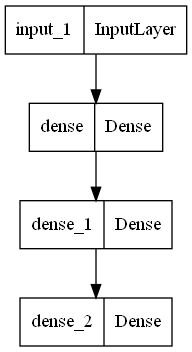

In [11]:
import os

plot_img_dir = 'plot_model'

if not os.path.exists(plot_img_dir):
    os.mkdir(plot_img_dir)

keras.utils.plot_model(model, f"{plot_img_dir}/my_first_model.png")

선택적으로 플로팅 된 그래프에서 각 레이어의 입력 및 출력 모양을 표시합니다.

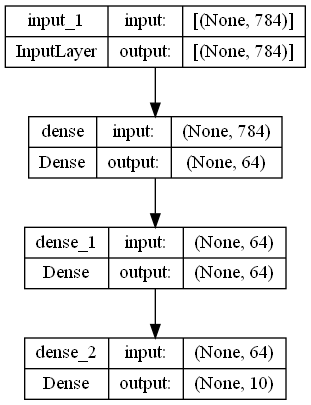

In [12]:
keras.utils.plot_model(model, f"{plot_img_dir}/my_first_model_with_shape_info.png", show_shapes=True)

이 그림과 코드는 거의 동일합니다. 코드 버전에서 연결 화살표는 호출 작업으로 대체됩니다.

"계층 그래프"는 딥 러닝 모델에 대한 직관적인 정신 이미지이며 Functinoal API는 이를 밀접하게 반영하는 모델을 만드는 방법입니다.

### 훈련, 평가 및 추론

훈련, 평가 및 추론은 Sequential 모델과 기능 API를 사용하여 빌드 된 모델에 대해 정확히 동일한 방식으로 작동합니다.

Model 클래스는 기본 제공 훈련 루프 ( fit() 메서드)와 기본 제공 평가 루프 ( evaluate() 메서드)를 제공합니다. 지도 학습 (예 : GAN ) 이상의 학습 루틴을 구현하기 위해 이러한 루프 를 쉽게 사용자 정의 할 수 있습니다.

여기에서 MNIST 이미지 데이터를로드하고 벡터로 변형하고 데이터에 모델을 맞춘 다음 (검증 분할에서 성능을 모니터링하면서) 테스트 데이터에서 모델을 평가합니다.

In [14]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/2
750/750 [==============================] - 2s 2ms/step - loss: 0.1186 - accuracy: 0.9642 - val_loss: 0.1173 - val_accuracy: 0.9655
Epoch 2/2
750/750 [==============================] - 1s 2ms/step - loss: 0.0939 - accuracy: 0.9715 - val_loss: 0.1074 - val_accuracy: 0.9697
313/313 - 0s - loss: 0.1026 - accuracy: 0.9708 - 293ms/epoch - 936us/step
Test loss: 0.10263442248106003
Test accuracy: 0.97079998254776
